# Exploring venues in Mumbai, India

## Table of Contents

* [Introduction](#introduction)
* [Data Collection from APIs](#data_collection)
* [Data Cleaning](#data_cleaning)
* [Methodolgy](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction <a name="introduction"></a>

The aim of the project is to identify venues in Mumbai, India based on their rating and average prices. In this notebook, we will identify various venues in the city of **Mumbai, India**, using **Foursquare API** and **Zomato API**, to help visitors select the area of the city that suit them the best.

Mumbai is port city having a shape more longer than circular. We know that the northern part of the city is mostly residential complexes, so I've set the centre of Mumbai to a little more towards the south than the actual coordinates of the airport.

Now, the problem statement of the project was to help people decide the place that they want to visit, having a very short window of time. It's like for the cases where you've 5-6 hours of time and it's just enough to check out one place.

## Data Collection from APIs <a name="data_collection"></a>

To begin with, we will take a look at **Mumbai**  on the Map using the `folium` library.

We will also fetch the data from **two different APIs**.
* **Foursquare API:** We will use the Foursquare API to fetch venues in Mumbai starting from the designated point upto 15 Kilometers in each direction.
* **Zomato API:** The Zomato API provides information about various venues including the complete address, user ratings, price for two people, price range and a lot more. Zomato is more popular in India than Foursquare hence it provides more accurate data that we can leverage.

### Mumbai

**Mumbai** is the largest city in India and is composed of many areas. There are many venues (especially restaurants, hotels and cafes) which can be explored.

We could fetch the coordinates of Mumbai but since that provides us with the coordinates of the centre, and since, like mentioned above, we want to exclude the northern residential areas hence we'll manually enter the values.

In [2]:
MUM_LATITUDE = '19.0515455'
MUM_LONGITUDE = '72.8488861'
print('The geograpical coordinates of Mumbai are {}, {}.'.format(MUM_LATITUDE, MUM_LONGITUDE))

The geograpical coordinates of Mumbai are 19.0515455, 72.8488861.


Let's use the `folium` library to create a **complete map zoomed on Mumbai**. We'll also plot a marker on the coordinates we just identified above. This would give us a relatively good look at the point from which we'll look at all directions for 15km. Notice that the point is a little to the south of the actual centre, which is somewhere around the airport(flight logo).

In [3]:
import folium

mumbai_map = folium.Map(location = [MUM_LATITUDE, MUM_LONGITUDE], zoom_start = 13)
folium.Marker([MUM_LATITUDE, MUM_LONGITUDE]).add_to(mumbai_map)
mumbai_map.save("maps/Mumbai Map.html")
mumbai_map

### Foursquare API

We begin by fetching a total of all venues in **Mumbai** upto a range of 15 Kilometers using the Foursquare API. The Foursquare API has the `explore` API which allows us to find venue recommendations within a given radius from the given coordinates. We will use this API to find all the venues we need.

In [4]:
FOURSQUARE_CLIENT_ID = 'Client-id' #hidden for safety
FOURSQUARE_CLIENT_SECRET = 'Client-Secret' #hidden for safety
RADIUS = 15000 # 15 Km
NO_OF_VENUES = 100
VERSION = '20200919' # Current date

We define the `get_category_type` method to get the correct category for each venue.

In [5]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

We'll call the API over and over till we get all venues from the API within the given distance. The maximum venues this API can fetch is 100, so we will fetch all venues by iteratively calling this API and increasing the offset each time.

* Foursquare API requires client_id, and client_secret to function which can be accessed after creating a developer account. 
* We will set the radius as 15 Kilometers. 
* The version is a required parameter which defines the date on which we are browsing so that it retrieves the latest data.

In [6]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from pandas import json_normalize
import requests

pd.set_option('display.max_rows', None)

offset = 0
total_venues = 0
foursquare_venues = pd.DataFrame(columns = ['name', 'categories', 'lat', 'lng'])

while (True):
    url = ('https://api.foursquare.com/v2/venues/explore?client_id={}'
           '&client_secret={}&v={}&ll={},{}&radius={}&limit={}&offset={}').format(FOURSQUARE_CLIENT_ID, 
                                                                        FOURSQUARE_CLIENT_SECRET, 
                                                                        VERSION, 
                                                                        MUM_LATITUDE, 
                                                                        MUM_LONGITUDE, 
                                                                        RADIUS,
                                                                        NO_OF_VENUES,
                                                                        offset
                                                                        )
    result = requests.get(url).json()
    venues_fetched = len(result['response']['groups'][0]['items'])
    total_venues = total_venues + venues_fetched
    print("Total {} venues fetched within a total radius of {} Km".format(venues_fetched, RADIUS/1000))

    venues = result['response']['groups'][0]['items']
    venues = json_normalize(venues)

    # Filter the columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    venues = venues.loc[:, filtered_columns]

    # Filter the category for each row
    venues['venue.categories'] = venues.apply(get_category_type, axis = 1)

    # Clean all column names
    venues.columns = [col.split(".")[-1] for col in venues.columns]
    foursquare_venues = pd.concat([foursquare_venues, venues], axis = 0, sort = False)
    
    if (venues_fetched < 100):
        break
    else:
        offset = offset + 100

foursquare_venues = foursquare_venues.reset_index(drop = True)
print("\nTotal {} venues fetched".format(total_venues))

Total 100 venues fetched within a total radius of 15.0 Km
Total 100 venues fetched within a total radius of 15.0 Km
Total 27 venues fetched within a total radius of 15.0 Km

Total 227 venues fetched


### Zomato API

The Zomato API allows using its search API to search for any given venue based on certain search filters such as query, latitude, longitude and more. Zomato also requires a Zomato user key which can be accessed with a developer account.

We'll use the `name`, `lat`, and `lng` values of various venues fetched from Foursquare API to use the search API and get more information regarding each venue.

* The query will be the name of the venue.
* The count defines the number of restaurants we want to fetch. As we have the exact location coordinates, we'll fetch only one.

In [7]:
headers = {'user-key': 'user-key-here'} #hidden for safety
venues_information = []

for index, row in foursquare_venues.iterrows():
    print("Fetching data for venue: {}".format(index + 1))
    venue = []
    url = ('https://developers.zomato.com/api/v2.1/search?q={}' + 
          '&start=0&count=1&lat={}&lon={}&sort=real_distance').format(row['name'], row['lat'], row['lng'])
    result = requests.get(url, headers = headers).json()
    if (len(result['restaurants']) > 0):
        venue.append(result['restaurants'][0]['restaurant']['name'])
        venue.append(result['restaurants'][0]['restaurant']['location']['latitude'])
        venue.append(result['restaurants'][0]['restaurant']['location']['longitude'])
        venue.append(result['restaurants'][0]['restaurant']['average_cost_for_two'])
        venue.append(result['restaurants'][0]['restaurant']['price_range'])
        venue.append(result['restaurants'][0]['restaurant']['user_rating']['aggregate_rating'])
        venue.append(result['restaurants'][0]['restaurant']['location']['address'])
        venues_information.append(venue)
    else:
        venues_information.append(np.zeros(6))
    
zomato_venues = pd.DataFrame(venues_information, 
                                  columns = ['venue', 'latitude', 
                                             'longitude', 'price_for_two', 
                                             'price_range', 'rating', 'address'])

Fetching data for venue: 1
Fetching data for venue: 2
Fetching data for venue: 3
Fetching data for venue: 4
Fetching data for venue: 5
Fetching data for venue: 6
Fetching data for venue: 7
Fetching data for venue: 8
Fetching data for venue: 9
Fetching data for venue: 10
Fetching data for venue: 11
Fetching data for venue: 12
Fetching data for venue: 13
Fetching data for venue: 14
Fetching data for venue: 15
Fetching data for venue: 16
Fetching data for venue: 17
Fetching data for venue: 18
Fetching data for venue: 19
Fetching data for venue: 20
Fetching data for venue: 21
Fetching data for venue: 22
Fetching data for venue: 23
Fetching data for venue: 24
Fetching data for venue: 25
Fetching data for venue: 26
Fetching data for venue: 27
Fetching data for venue: 28
Fetching data for venue: 29
Fetching data for venue: 30
Fetching data for venue: 31
Fetching data for venue: 32
Fetching data for venue: 33
Fetching data for venue: 34
Fetching data for venue: 35
Fetching data for venue: 36
F

## Data Cleaning <a name="data_cleaning"></a>

The data from multiple resources might not always align. Thus, it is **important to combine the data retrieved from multiple resources properly**.

We'll first plot the two data points on the map. We'll then try to combine data points that have their latitude and longitude values very close to one another. From the remaining selected venues, we will inspect the venues to ensure that any remaining mismatched venues are also removed from the final dataset of venues before we begin any analysis.

We will first plot the Foursquare data on the map.

In [7]:
mumbai_map = folium.Map(location = [MUM_LATITUDE, MUM_LONGITUDE], zoom_start = 13)

for name, latitude, longitude in zip(foursquare_venues['name'], foursquare_venues['lat'], foursquare_venues['lng']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'green',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(mumbai_map)  

mumbai_map.save("maps/Venues by Foursquare.html")
mumbai_map

From the map, we can infer that there are clusters of venues around **Powai-Ghatkopar**, **Parel**, **Colaba**, **Juhu-Versova** and **Bandra**. We can also plot the category count and see the major type of venues that exist.

We will also plot the Zomato data on the map.

In [8]:
mumbai_map = folium.Map(location = [MUM_LATITUDE, MUM_LONGITUDE], zoom_start = 13)

for venue, address, latitude, longitude in zip(zomato_venues['venue'], zomato_venues['address'], 
                                               zomato_venues['latitude'], zomato_venues['longitude']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'red',
        fill = True,
        fill_color = '#cc3535',
        fill_opacity = 0.7,
        parse_html = False).add_to(mumbai_map)  

mumbai_map.save("maps/Venues by Zomato.html")
mumbai_map

We can see that there are many venues identified by both Foursquare and Zomato. 

To combine the two datasets, We'll have to check that the latitude and longitude values of each corresponding venue match. Thus, We'll round both the latitude and longitude values upto 4 decimal places. Then, We'll calculate the difference between the corresponding latitude and longitude values and see if the difference is less than 0.0004 which should ideally mean that the two locations are same.

In [9]:
foursquare_venues['lat'] = foursquare_venues['lat'].apply(lambda lat: round(float(lat), 4))
foursquare_venues['lng'] = foursquare_venues['lng'].apply(lambda lng: round(float(lng), 4))
zomato_venues['latitude'] = zomato_venues['latitude'].apply(lambda lat: round(float(lat), 4))
zomato_venues['longitude'] = zomato_venues['longitude'].apply(lambda lng: round(float(lng), 4))

In [10]:
dataset = pd.concat([foursquare_venues, zomato_venues], axis = 1)
dataset['lat_diff'] = dataset['latitude'] - dataset['lat']
dataset['lng_diff'] = dataset['longitude'] - dataset['lng']

In [11]:
selected_venues = dataset[(abs(dataset['lat_diff']) <= 0.0004) & (abs(dataset['lng_diff']) <= 0.0004)].reset_index(drop = True)
selected_venues

,name,categories,lat,lng,venue,latitude,longitude,price_for_two,price_range,rating,address,lat_diff,lng_diff
0,Escobar,Lounge,19.0602,72.8364,Escobar - Tapas Bar,19.0600,72.8361,2500.0,4.0,4.1,"4th Floor, VN Sphere, Turner And Linking Road,...",-0.0002,-0.0003
1,Chocolateria San Churro,Dessert Shop,19.0619,72.8345,Chocolateria San Churro,19.0619,72.8346,700.0,2.0,4.5,"11, Silver Pearl, Waterfield Road, Linking Roa...",0.0000,0.0001
2,Bastian,Seafood Restaurant,19.0636,72.8348,Khow Chow,19.0636,72.8348,1500.0,3.0,4.4,"Shop 2, New Kamal Chs, Waterfield Road, Linkin...",0.0000,0.0000
3,Bombay Salad Co.,Salad Place,19.0647,72.8309,Bombay Salad Co.,19.0648,72.8308,900.0,2.0,4.7,"Shop 1, 16th Road, Linking Road, Bandra West, ...",0.0001,-0.0001
4,Bombay Coffee House,Café,19.0634,72.8347,Bombay Coffee House,19.0634,72.8346,750.0,2.0,4.2,"248, Neelkamal Building, Opposite National Col...",0.0000,-0.0001
5,Punjab Sweet House And Restaurant,Indian Restaurant,19.0626,72.8294,Cocoaroma,19.0629,72.8292,650.0,2.0,3.4,"G 2, Jonelia 214, Saint Andrews Road, Pali Hil...",0.0003,-0.0002
6,Indigo Deli,Deli / Bodega,19.0617,72.8300,Indigo Burger Project,19.0617,72.8300,400.0,1.0,4.0,"8, Fatima Villa, 29th Road, Pali Mala Road, Pa...",0.0000,0.0000
7,Café Madras,Café,19.0277,72.8552,Cafe Madras,19.0277,72.8552,250.0,1.0,4.8,"38 B, Circle House, King's Circle Near Maheshw...",0.0000,0.0000
8,Candies,Restaurant,19.0497,72.8298,Candies,19.0497,72.8298,650.0,2.0,4.1,"ONGC Complex, Near Lilavati Hospital, Reclamat...",0.0000,0.0000
9,Ram Ashraya,Vegetarian / Vegan Restaurant,19.0281,72.8517,Hotel Ram Ashraya,19.0281,72.8517,200.0,1.0,4.9,"Bhandarkar Road, Matunga East, Mumbai",0.0000,0.0000


Taking a look at the names of venues from both APIs, some names are a complete mismatch.

**Category 1:** There are venues that have specific restaurants/cafes inside them as provided by Zomato API (Secondo - The Continental Chicken in Phoenix Marketcity).

**Category 2:** Two locations are so close by that they have practically same latitude and longitude values (Shivaji Park and The Malvan Fusion Cafe).

**Category 3:** Some have been replaced with new restaurants (Bastian has now been replaced by Khow Chow).

The venues which belong to category 1 and category 3 are alright to keep, the venues that fall in category 2 should be removed.

In [12]:
selected_venues = selected_venues.drop([9, 12, 72]).reset_index(drop = True)

I'll now select the venue name from **Zomato API**. I'll also get the average price per person by dividing the column `price_for_two` by 2 and removing this column from the dataset along with other unnecessary columns.

In [13]:
selected_venues['average_price'] = selected_venues['price_for_two']/2
selected_venues = selected_venues.drop(columns = ['name', 'lat', 'lng', 'lat_diff', 'lng_diff', 'price_for_two'])

Let's take a look at the final dataset that is left with us.

In [14]:
selected_venues.head(5)

,categories,venue,latitude,longitude,price_range,rating,address,average_price
0,Lounge,Escobar - Tapas Bar,19.0600,72.8361,4.0,4.1,"4th Floor, VN Sphere, Turner And Linking Road,...",1250.0
1,Dessert Shop,Chocolateria San Churro,19.0619,72.8346,2.0,4.5,"11, Silver Pearl, Waterfield Road, Linking Roa...",350.0
2,Seafood Restaurant,Khow Chow,19.0636,72.8348,3.0,4.4,"Shop 2, New Kamal Chs, Waterfield Road, Linkin...",750.0
3,Salad Place,Bombay Salad Co.,19.0648,72.8308,2.0,4.7,"Shop 1, 16th Road, Linking Road, Bandra West, ...",450.0
4,Café,Bombay Coffee House,19.0634,72.8346,2.0,4.2,"248, Neelkamal Building, Opposite National Col...",375.0


I'll drop the venues which have `0.0` rating as it means it's not been rated yet.

In [15]:
selected_venues = selected_venues[selected_venues['rating'] != 0.0]
print("Total venues available: {}".format(selected_venues.shape[0]))

Total venues available: 113


## Methodology <a name="methodology"></a>

This project aims at identifying the venues in Mumbai based on their rating and average costs. This would enable any visitor to identify the venues he/she wants to visit based on their rating and cost preference.

As a first step, we retrieved the **data from two APIs (Foursquare and Zomato)**. We extract venue information from the starting point, upto a distance of 15 Km, usinf Foursquare. Then, the latitude and longitude values are used to fetch venue rating and price from Zomato.

Secondly, we then **explored the data** retrieved from the two APIs on the map and identified the top category types. The **data from the two sources is cleaned and merged** based on the name, latitude and longitude values from the two sources. The final dataset would include the rating and price values for each venue.

Next, we'll **analyse the data** that we created based on the ratings and price of each venue. We'll **identify places where many venues are located** so that any visitor can go to one place and enjoy the option to choose amongst many venue options. We'll also explore **areas that are high rated and those that are low rated** while also plotting the **map of high and low priced venues**. 

Lastly, we'll **cluster the venues** based on the available information of each venue and the location. This will allow us to clearly identify which venues can be recommended and with what characteristics and we'll also be able **identify places where many venues are located** so that any visitor can go to one place and enjoy the option to choose amongst many venue options. 

Finally, we'll discuss and conclude which venues to be explored based on visitor requirement of rating and cost.

## Analysis <a name="analysis"></a>

The complete dataset is now in its final form. 

We will **inspect these venues based on their rating**. The rating of a venue are based on user reviews and belongs to a range from 1 to 5. We'll also **analyse the venues based on their price per person as well as the price range**. 

### Categories

We have various types of venues in the final dataset. We will take a look at the venues and check which are the majority venue categories in the list.

<BarContainer object of 49 artists>

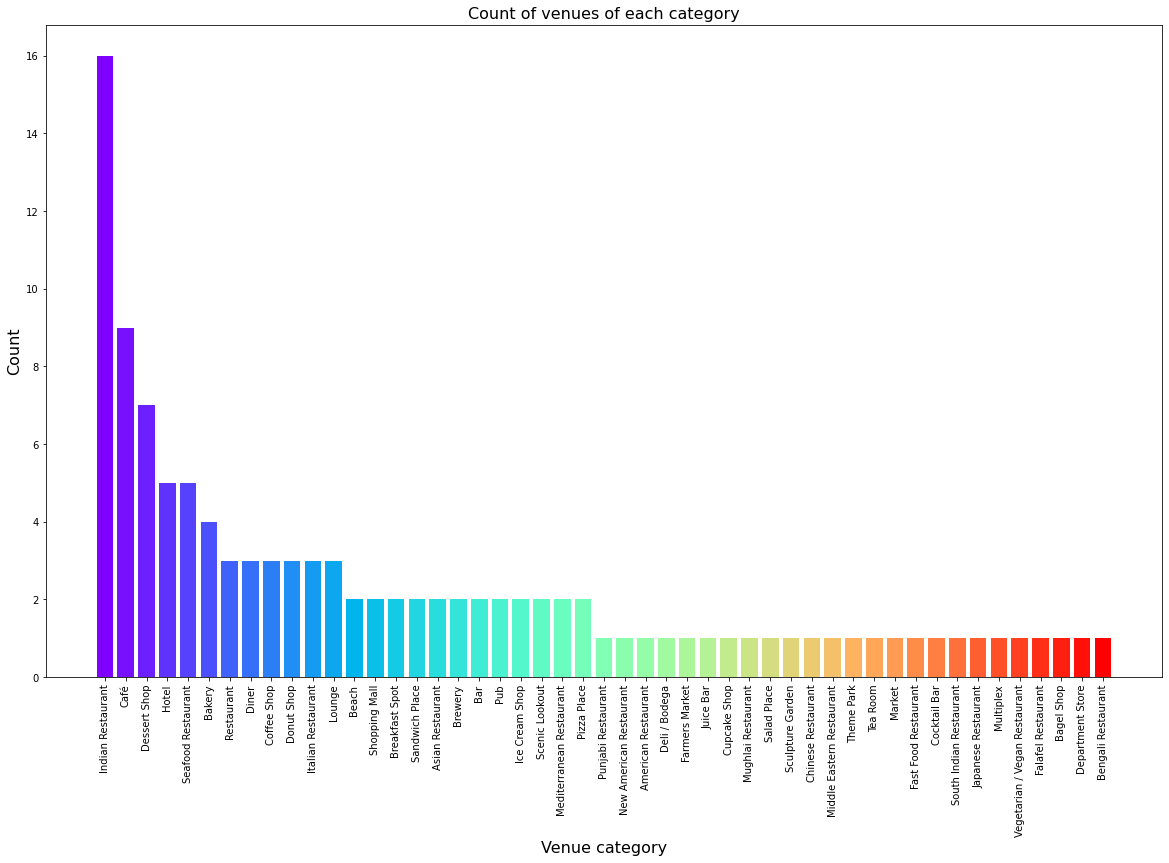

In [16]:
venue_distribution = selected_venues['categories'].value_counts()
colors = cm.rainbow(np.linspace(0, 1, len(venue_distribution.index)))
plt.figure(figsize = (20, 12))
plt.xticks(rotation = 90)
plt.xlabel("Venue category", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues of each category", fontsize = 16)
plt.bar(venue_distribution.index, venue_distribution.values, color = colors)

As we can see the majority venues are **Cafe** and **Indian Restaurant**. So, if as a tourist, you're looking for cafes and Indian restaurants, you're in luck.

### Rating

Rating of a venue is an important factor on which a visitor decides whether it is worth it to visit the place. To cater to this, we will first see what is the average rating for all the venues in the city. Next, we will plot the venues on the map and color code them.

We'll first identify the various rating values and plot them as a bar plot with their counts to see the most common rating.

Text(0.5, 1.0, 'Count of venues with given rating')

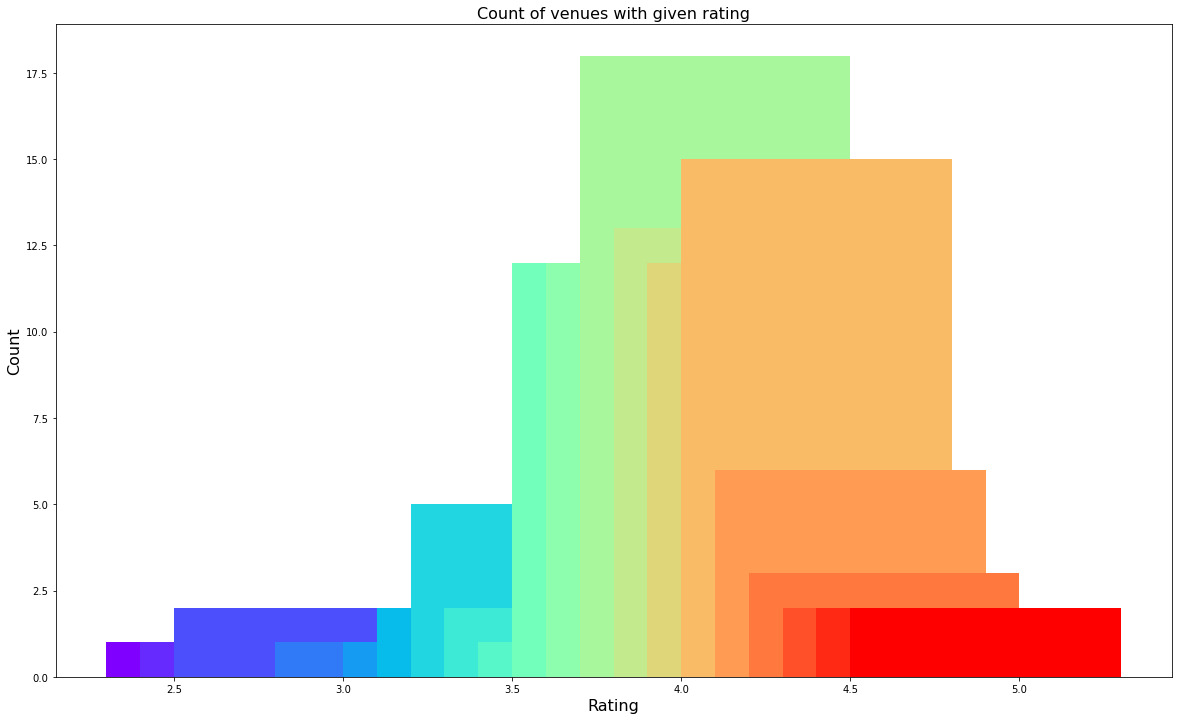

In [17]:
selected_venues['rating'] = selected_venues['rating'].astype(float)
rating = selected_venues['rating'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.bar(rating.index, rating.values, color = cm.rainbow(np.linspace(0, 1, len(rating.index))))
plt.xlabel("Rating", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues with given rating", fontsize = 16)

From the plot above, it is clear that **majority venues** have their **rating above to 3.7 to 4**. This is decent rating.

Let's create bins for various ratings and plot them in different colors on the map. The ratings will be divided between 4 bins:
* 1 to 2
* 2 to 3
* 3 to 4
* 4 to 5

In [18]:
bins = [1.0, 2.0, 3.0, 4.0, 5.0]
labels = ['Low', 'Okay', 'Good', 'Very good']
selected_venues['rating_bin'] = pd.cut(selected_venues['rating'].astype(float), bins = bins, labels = labels, include_lowest = True)

Now, we will plot the venues on the map.

In [19]:
color_map = {'Low': 'red', 'Okay': 'orange', 'Good': 'green', 'Very good': 'darkgreen'}

mumbai_map = folium.Map(location = [MUM_LATITUDE, MUM_LONGITUDE], zoom_start = 13)

for name, address, latitude, longitude, rating_bin in zip(selected_venues['venue'], 
                                                          selected_venues['address'], 
                                                          selected_venues['latitude'], 
                                                          selected_venues['longitude'], 
                                                          selected_venues['rating_bin']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[rating_bin]),
        popup = label).add_to(mumbai_map)  

mumbai_map.save("maps/Venues Ratings.html")
mumbai_map

The map has the location of all the venues. It seems like the majority of locations have good rating. This also points to the fact that well running places also care about their online presence on Foursquare and hence most locations have a high rating on Zomato as well.

### Price

We will now take a look the venues based on the price values. We have two price features for our venues, one is `average_price` which defines the average cost for one person and the other is `price_range` which determines the price range as defined by Zomato.

We will first explore the `average_price` using a scatter plot between the price and the count of venues with that average price. We'll size the points based on the price to highlight their price.

Text(0.5, 1.0, 'Count of venues with given average price')

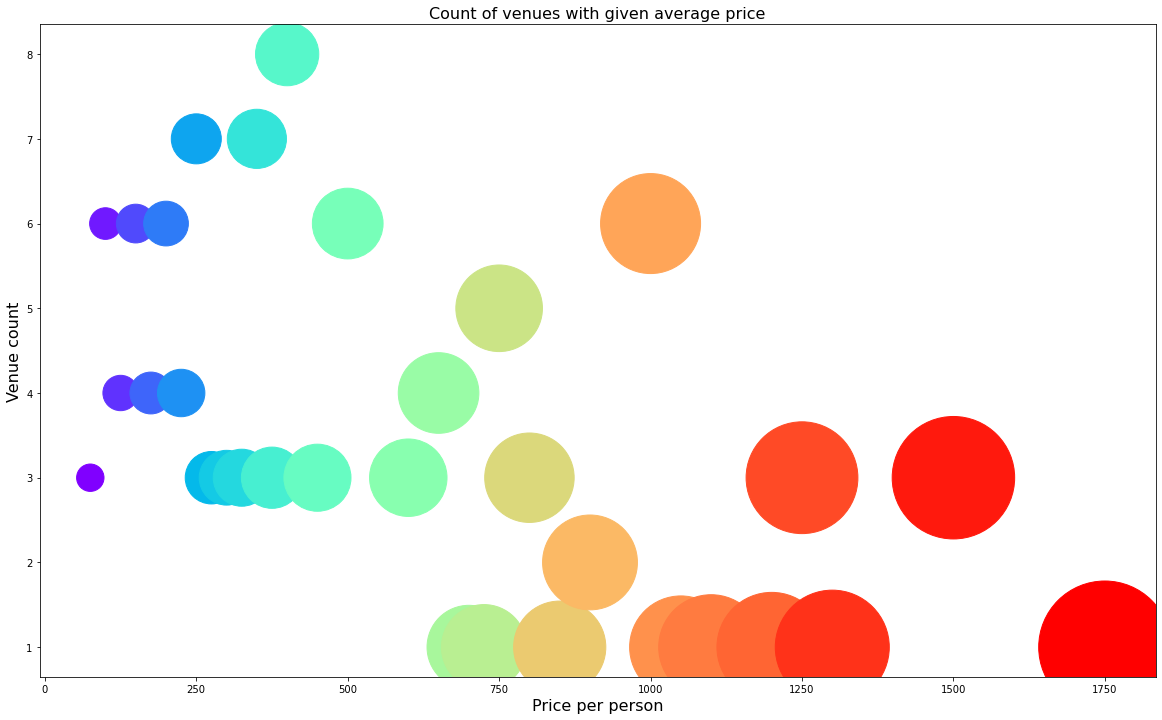

In [20]:
average_prices = selected_venues['average_price'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.scatter(average_prices.index, 
            average_prices.values, 
            s = average_prices.index*10, 
            c = cm.rainbow(np.linspace(0, 1, len(average_prices.index))))
plt.xlabel("Price per person", fontsize = 16)
plt.ylabel("Venue count", fontsize = 16)
plt.title("Count of venues with given average price", fontsize = 16)

From the plot above we can see that a large number of venues have an average price between Rs 250 and Rs 1000.
This also gives us the idea of cost of outing in Mumbai, as average cost of dining out in locations is among the highest in the country.

Users might also be interested in going to a place that fits in their budget. I'll use the `price_range` column to plot the venues on a map. We'll represent the venues with lower price in green and move towards red as the price increases.

In [21]:
color_map = {'1.0': 'green', '2.0': 'darkgreen', '3.0': 'orange', '4.0': 'red'}

mumbai_map = folium.Map(location = [MUM_LATITUDE, MUM_LONGITUDE], zoom_start = 13)

for name, address, latitude, longitude, price_range in zip(selected_venues['venue'], 
                                                           selected_venues['address'], 
                                                           selected_venues['latitude'], 
                                                           selected_venues['longitude'], 
                                                           selected_venues['price_range'].astype(str)):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[price_range]),
        popup = label).add_to(mumbai_map)  

mumbai_map.save("maps/Venues Prices.html")
mumbai_map

1. Most high priced are spread out, as expected.
2. Moderate priced venues are located near the Powai-Ghatkopar region as they have a higher number of malls.
3. The green markers are the cheao venues, normally the street food outlets. They're more common around the beach line as people like to hangout there and have street food.

### Clustering - A

We will now cluster all these venues based on their price range and rating to identify similar venues and the relationship amongst them. We'll cluster the venues into three separate groups.

In [22]:
from sklearn.cluster import KMeans

NO_OF_CLUSTERS = 3

clustering_a = selected_venues.drop(['venue', 'address', 'rating_bin', 'categories', 'latitude', 'longitude'], 1)
kMeans = KMeans(n_clusters = NO_OF_CLUSTERS, random_state = 0).fit(clustering_a)
selected_venues.insert(0, 'cluster_labels_a', kMeans.labels_)
selected_venues.head(5)

,cluster_labels_a,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,0,Lounge,Escobar - Tapas Bar,19.0600,72.8361,4.0,4.1,"4th Floor, VN Sphere, Turner And Linking Road,...",1250.0,Very good
1,1,Dessert Shop,Chocolateria San Churro,19.0619,72.8346,2.0,4.5,"11, Silver Pearl, Waterfield Road, Linking Roa...",350.0,Very good
2,2,Seafood Restaurant,Khow Chow,19.0636,72.8348,3.0,4.4,"Shop 2, New Kamal Chs, Waterfield Road, Linkin...",750.0,Very good
3,1,Salad Place,Bombay Salad Co.,19.0648,72.8308,2.0,4.7,"Shop 1, 16th Road, Linking Road, Bandra West, ...",450.0,Very good
4,1,Café,Bombay Coffee House,19.0634,72.8346,2.0,4.2,"248, Neelkamal Building, Opposite National Col...",375.0,Very good


In [24]:
mumbai_map = folium.Map(location = [MUM_LATITUDE, MUM_LONGITUDE], zoom_start = 13)
color_map = { 0: 'green', 1: 'red', 2: 'blue'}

# add venues to the map
markers_colors = []
for venue, address, cluster, latitude, longitude in zip(selected_venues['venue'], 
                                                        selected_venues['address'], 
                                                        selected_venues['cluster_labels_a'], 
                                                        selected_venues['latitude'], 
                                                        selected_venues['longitude']):
    label = folium.Popup(str(venue) + ', ' + str(address), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = color_map[cluster],
        fill = True,
        fill_color = color_map[cluster],
        fill_opacity = 0.7).add_to(mumbai_map)

# add cluster centers to the map
for index, cluster in enumerate(kMeans.cluster_centers_):
    latitude = cluster[0]
    longitude = cluster[1]
    label = folium.Popup("Cluster: " + str(index), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 10,
        popup = label,
        color = color_map[index],
        fill = True,
        fill_color = color_map[index],
        fill_opacity = 0.7).add_to(mumbai_map)

mumbai_map.save("maps/Venues Clusters.html")
mumbai_map

From the map, we see the two clusters:
1. The zeroth cluster venues are negligible on the map
2. The first cluster is spread across the whole city and includes the majority venues.
3. The second cluster is very sparsely spread and has very limited venues.

Let's check the venues of the two clusters.

In [26]:
result = selected_venues[selected_venues['cluster_labels_a'] == 0]
print("Cluster 0")
result.head(10).reset_index(drop = True)

Cluster 0


,cluster_labels_a,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,0,Lounge,Escobar - Tapas Bar,19.0600,72.8361,4.0,4.1,"4th Floor, VN Sphere, Turner And Linking Road,...",1250.0,Very good
1,0,Mediterranean Restaurant,Indigo Delicatessen,19.1364,72.8275,4.0,4.4,"Clifton Trishool, Off Link Road, Oshiwara Vill...",1200.0,Very good
2,0,Hotel,Harbour Bar - The Taj Mahal Palace,18.9221,72.8337,4.0,4.0,"The Taj Mahal Palace & Tower, Apollo Bunder, C...",1250.0,Good
3,0,Hotel,Tiara Restaurant & Bar - Meluha The Fern,19.1179,72.9111,4.0,4.3,"Meluha The Fern, Ecotel Hotel, Central Avenue,...",1500.0,Very good
4,0,Mediterranean Restaurant,Breeze Lounge,19.1116,72.9092,4.0,4.1,"8th Floor, A Wing, Supreme Business Park, Hira...",1300.0,Very good
5,0,Hotel,Dome - InterContinental,18.9349,72.8241,4.0,4.4,"Hotel InterContinental, 135, Churchgate, Mumbai",1750.0,Very good
6,0,Pub,Woodside Inn,18.9246,72.8320,4.0,4.6,"Opposite Regal Cinema, Wodehouse Road, Colaba,...",1100.0,Very good
7,0,Italian Restaurant,Lake View Cafe - Renaissance Hotel,19.1351,72.9018,4.0,4.1,"2 & 3 B, Chinmayanand Ashram, Powai, Mumbai",1500.0,Very good
8,0,Lounge,Lake View Cafe - Renaissance Hotel,19.1351,72.9018,4.0,4.1,"2 & 3 B, Chinmayanand Ashram, Powai, Mumbai",1500.0,Very good
9,0,Japanese Restaurant,Harbour Bar - The Taj Mahal Palace,18.9221,72.8337,4.0,4.0,"The Taj Mahal Palace & Tower, Apollo Bunder, C...",1250.0,Good


In [27]:
print("These venues for cluster 0 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 0 have mean price range of 4.00 and rating spread around 4.21


In [28]:
result = selected_venues[selected_venues['cluster_labels_a'] == 1]
print("Cluster 1")
result.head(10).reset_index(drop = True)

Cluster 1


,cluster_labels_a,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,1,Dessert Shop,Chocolateria San Churro,19.0619,72.8346,2.0,4.5,"11, Silver Pearl, Waterfield Road, Linking Roa...",350.0,Very good
1,1,Salad Place,Bombay Salad Co.,19.0648,72.8308,2.0,4.7,"Shop 1, 16th Road, Linking Road, Bandra West, ...",450.0,Very good
2,1,Café,Bombay Coffee House,19.0634,72.8346,2.0,4.2,"248, Neelkamal Building, Opposite National Col...",375.0,Very good
3,1,Indian Restaurant,Cocoaroma,19.0629,72.8292,2.0,3.4,"G 2, Jonelia 214, Saint Andrews Road, Pali Hil...",325.0,Good
4,1,Deli / Bodega,Indigo Burger Project,19.0617,72.8300,1.0,4.0,"8, Fatima Villa, 29th Road, Pali Mala Road, Pa...",200.0,Good
5,1,Café,Cafe Madras,19.0277,72.8552,1.0,4.8,"38 B, Circle House, King's Circle Near Maheshw...",125.0,Very good
6,1,Restaurant,Candies,19.0497,72.8298,2.0,4.1,"ONGC Complex, Near Lilavati Hospital, Reclamat...",325.0,Very good
7,1,Indian Restaurant,Cupcake Factory,19.0619,72.8295,1.0,4.1,"Ground Floor, G-3, 78, Pali Village, Bandra We...",125.0,Very good
8,1,Scenic Lookout,Joseph's Kitchen,19.0669,72.8228,2.0,3.9,"29th Road, Prarthana, Pali Hill, Bandra West, ...",250.0,Good
9,1,Café,China Blue,19.0606,72.8244,2.0,3.9,"Ray's Co-operative Housing Society, New Kantwa...",400.0,Good


In [29]:
print("These venues for cluster 1 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 1 have mean price range of 1.64 and rating spread around 4.04


In [30]:
result = selected_venues[selected_venues['cluster_labels_a'] == 2]
print("Cluster 2")
result.head(10).reset_index(drop = True)

Cluster 2


,cluster_labels_a,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,2,Seafood Restaurant,Khow Chow,19.0636,72.8348,3.0,4.4,"Shop 2, New Kamal Chs, Waterfield Road, Linkin...",750.0,Very good
1,2,Seafood Restaurant,The Homemade Cafe & Bar,19.1036,72.8269,3.0,4.1,"Near Petrol Pump, Juhu Tara Road, Juhu, Mumbai",600.0,Very good
2,2,Restaurant,Ivy Restaurant And Banquets,19.0696,72.9004,3.0,4.2,"Near Shopper's Stop, Amar Mahal, M G Road, Che...",800.0,Very good
3,2,Asian Restaurant,Orchids,19.0616,72.9016,3.0,4.4,"Hotel Royal Orchid, NG Acharya Marg, Chembur, ...",600.0,Very good
4,2,Hotel,Gajalee,18.9945,72.8244,3.0,4.2,"Phoenix Mill Compound, High Street Phoenix, Se...",750.0,Very good
5,2,Beach,Oriental Bowl - Ramada Palmgrove,19.0981,72.8270,4.0,3.2,"Ramada Hotel Palm Grove, Juhu Beach Road, Juhu...",1000.0,Good
6,2,Indian Restaurant,Mehman Nawazi,19.1115,72.9092,3.0,4.0,"8th Floor, A Wing, Supreme Business Park, Hira...",725.0,Good
7,2,Café,Le Café,19.0617,72.8997,3.0,4.2,"1st Road, Opposite B.M.C Office, Chembur, Mumbai",750.0,Very good
8,2,Indian Restaurant,Mantra Dining Bar,19.1234,72.9131,3.0,4.2,"Ground Floor, Powai Plaza, Powai, Mumbai",650.0,Very good
9,2,Bar,Woodside Inn,19.1484,72.8315,3.0,4.3,"New Link Plaza, Next to Oshiwara Police Statio...",900.0,Very good


In [42]:
print("These venues for cluster 2 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 2 have mean price range of 3.26 and rating spread around 4.27


### Clustering - B

We will now cluster all these venues based on their location to identify areas most populated with venues.

In [39]:
from sklearn.cluster import KMeans

NO_OF_CLUSTERS = 5

clustering_b = selected_venues.drop(['cluster_labels_a','cluster_labels_b', 'venue', 'address', 'rating', 'rating_bin', 'categories', 'price_range', 'average_price'], 1)
kMeans = KMeans(n_clusters = NO_OF_CLUSTERS, random_state = 0).fit(clustering_b)
selected_venues['cluster_labels_b'] = kMeans.labels_
selected_venues.head(5)

,cluster_labels_b,cluster_labels_a,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,3,0,Lounge,Escobar - Tapas Bar,19.0600,72.8361,4.0,4.1,"4th Floor, VN Sphere, Turner And Linking Road,...",1250.0,Very good
1,3,1,Dessert Shop,Chocolateria San Churro,19.0619,72.8346,2.0,4.5,"11, Silver Pearl, Waterfield Road, Linking Roa...",350.0,Very good
2,3,2,Seafood Restaurant,Khow Chow,19.0636,72.8348,3.0,4.4,"Shop 2, New Kamal Chs, Waterfield Road, Linkin...",750.0,Very good
3,3,1,Salad Place,Bombay Salad Co.,19.0648,72.8308,2.0,4.7,"Shop 1, 16th Road, Linking Road, Bandra West, ...",450.0,Very good
4,3,1,Café,Bombay Coffee House,19.0634,72.8346,2.0,4.2,"248, Neelkamal Building, Opposite National Col...",375.0,Very good


In [40]:
mumbai_map = folium.Map(location = [MUM_LATITUDE, MUM_LONGITUDE], zoom_start = 13)
color_map = { 0: 'green', 1: 'red', 2: 'blue', 3: 'yellow', 4: 'black'}

# add venues to the map
markers_colors = []
for venue, address, cluster, latitude, longitude in zip(selected_venues['venue'], 
                                                        selected_venues['address'], 
                                                        selected_venues['cluster_labels_b'], 
                                                        selected_venues['latitude'], 
                                                        selected_venues['longitude']):
    label = folium.Popup(str(venue) + ', ' + str(address), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = color_map[cluster],
        fill = True,
        fill_color = color_map[cluster],
        fill_opacity = 0.7).add_to(mumbai_map)

# add cluster centers to the map
for index, cluster in enumerate(kMeans.cluster_centers_):
    latitude = cluster[0]
    longitude = cluster[1]
    label = folium.Popup("Cluster: " + str(index), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 10,
        popup = label,
        color = color_map[index],
        fill = True,
        fill_color = color_map[index],
        fill_opacity = 0.7).add_to(mumbai_map)

mumbai_map.save("maps/Venues Clusters.html")
mumbai_map

We can see five different clusters. The idea behind this is that if one has a small time window, because of the size of Mumbai, they may have to compromise on two distant location.
The clusters are:
1. Green- Juhu-Versova
2. Blue- Powai-Ghatkopar
3. Yellow- Bandra
4. Black- Parel
5. Red- Colaba

#### Results and Discussion <a name="results"></a>

Based on our analysis above, we can draw a number of conclusions that will be useful to aid any visitor visiting the city of Mumbai, India.

After collecting data from the **Foursquare** and **Zomato** APIs, we got a list of 227 different venues. However, not all venues from the two APIs were identical. Hence, we had to inspect their latitude and longitude values as well as names to combine them and remove all the outliers. This resulted in a total venue count of 113.

We identified that from the total set of venues, majority of them were **Cafes** and **Indian Restaurants**.

While the complete range of ratings range from 1 to 5, the **majority venues have ratings close to 4**. This means that most restaurants provide **good quality food and service** which is liked by the people of the city and the tourists, thus indicating the high rating. 

When we take a look at the price values of each venue, we explore that **many venues** have prices which are in the **range of Rs 250 to Rs 1000 for one person**. This also indicates the much known fact that the financial capital of India is indeed an expensive place. However, there are plenty of choices for cheaper venues as well. This is good thing as we have an option for every demand.

Through the first clustering we identified that there are **few venues** which are **high rated (4.21) and have a high price as well**. These belong to the Zeroth cluster. Then there are **many venues** which are **low priced and have average rating of 4.04**. These belong to the First cluster. The Second cluster has **limited venues** which are **moderately priced and are very high rated(4.27)**.

Throught the second clustering we identified the visiting area into five location clusters
The clusters are:
1. Green- Juhu-Versova
2. Blue- Powai-Ghatkopar
3. Yellow- Bandra
4. Black- Parel
5. Red- Colaba

A company can use this information to build up an online website/mobile application, to provide users with up to date information about various venues in the city based on the search criteria (name, rating and price).

## Conclusion <a name="conclusion"></a>

The purpose of this project was to explore the places that a person visiting Mumbai could visit. The venues have been identified using Foursquare and Zomato API and have been plotted on the map. The map reveals that there are five major areas a person can visit: Juhu-Versova area, Powai-Ghatkopar area, Bandra, Parel and Colaba. While these places have their own specialities, the fooding options can be chosen using the above clustering results.